In [1]:
from astropy.table import Table, Column, Row, MaskedColumn
import random
import time
from datetime import date
import calendar
import numpy as np
import matplotlib.pyplot as plt

First I read in my weather stats table - it probably is too basic a model but it is adequate for now, and for now I can get a feel for scatter based on runnign the "dry" and "wet" tables


In [2]:
wdata = Table.read('data/weather-average.csv', format='csv')

# wdata = Table.read('data/weather-average-dry.csv', format='csv')
# wdata = Table.read('weather-average-wet.csv', format='csv')

I then make new columns containing the cumulative fraction of time in each weather band (for use later). 

In [3]:
CumulativeBand1 = Column(wdata['Band1Percentage'], name='CumulativeBand1', format='.1f')
wdata.add_column(CumulativeBand1)
CumulativeBand2 = Column([x['CumulativeBand1']+x['Band2Percentage'] for x in wdata], name='CumulativeBand2', format='.1f')
wdata.add_column(CumulativeBand2)
CumulativeBand3 = Column([x['CumulativeBand2']+x['Band3Percentage'] for x in wdata], name='CumulativeBand3', format='.1f')
wdata.add_column(CumulativeBand3)
CumulativeBand4 = Column([x['CumulativeBand3']+x['Band4Percentage'] for x in wdata], name='CumulativeBand4', format='.1f')
wdata.add_column(CumulativeBand4)
CumulativeBand5 = Column([x['CumulativeBand4']+x['Band5Percentage'] for x in wdata], name='CumulativeBand5', format='.1f')
wdata.add_column(CumulativeBand5)

In [4]:
#wdata

I define a loook up dictionary for easy table access - months are not month values but rather positions in the table


In [5]:
dict = {'February': 0, 'March': 1, 'April': 2, 'May': 3, 'June': 4, 'July': 5, 'August': 6, 'September': 7, 'October': 8, 'November': 9, 'December': 10, 'January': 11}

Now I need to load in my schedule file from this it will detemrine the month and number of days I need to predict for. From this I need to be able to 

i) know month and number of days - to allocated a weather band for the night

ii) UT date and weather bad is then needed as input into Michael Polhen's code

In [6]:
sdata = Table.read('data/18A_schedule.csv', format='csv')

yearForTable = Column([int(x/10000) for x in sdata['Date']], name='Year')
monthForTable = Column([calendar.month_name[ int(int(x-((int(x/10000))*10000))/100)] for x in sdata['Date']], name='Month')
dayForTable = Column([x - (int(x/100)*100) for x in sdata['Date']], name='Day')

sdata.add_column(yearForTable)
sdata.add_column(monthForTable)
sdata.add_column(dayForTable)

print (len(sdata))
sdata

59


Date,Priority1,Priority2,Year,Month,Day
int64,str8,str8,int64,str8,int64
20180201,M16AL006,M17BL009,2018,February,1
20180202,M16AL006,M17BL009,2018,February,2
20180203,M16AL006,M17BL009,2018,February,3
20180204,M16AL006,M17BL009,2018,February,4
20180205,M16AL006,M17BL009,2018,February,5
20180206,M17BL004,--,2018,February,6
20180207,M17BL004,--,2018,February,7
20180208,M17BL004,--,2018,February,8
20180209,M17BL004,--,2018,February,9


In [21]:
# obtaines data when not PI time (PI in this example = UH and DDT and E&C)

PIdata =  sdata[sdata['Priority1']=='PI'] 

LAPsdata = sdata[sdata['Priority1']!='PI'] 

print (LAPsdata)

#monthgroupstable = sdata.group_by('Month') # group_by method.

#print (monthgroupstable.groups.keys) # can extract out the different groups in Month

# for now only look at one month

#for x in monthgroupstable.groups.keys:
#    print (str(x))
#    print (type(str(x)))

month = 'February'#'February'

MonthLAPSdata = LAPsdata[LAPsdata['Month']==month] 

numberofdays = (len(MonthLAPSdata))

MonthLAPSdata


  Date   Priority1 Priority2 Year  Month   Day
-------- --------- --------- ---- -------- ---
20180201  M16AL006  M17BL009 2018 February   1
20180202  M16AL006  M17BL009 2018 February   2
20180203  M16AL006  M17BL009 2018 February   3
20180204  M16AL006  M17BL009 2018 February   4
20180205  M16AL006  M17BL009 2018 February   5
20180206  M17BL004        -- 2018 February   6
20180207  M17BL004        -- 2018 February   7
20180208  M17BL004        -- 2018 February   8
20180209  M17BL004        -- 2018 February   9
20180210  M17BL004        -- 2018 February  10
     ...       ...       ...  ...      ... ...
20180313  M17BL002        -- 2018    March  13
20180314  M16AL001        -- 2018    March  14
20180315  M16AL001        -- 2018    March  15
20180316  M16AL001        -- 2018    March  16
20180317  M16AL001        -- 2018    March  17
20180318  M16AL001        -- 2018    March  18
20180323  M16AL004  M17BL011 2018    March  23
20180324  M16AL004  M17BL011 2018    March  24
20180325  M16

Date,Priority1,Priority2,Year,Month,Day
int64,str8,str8,int64,str8,int64
20180201,M16AL006,M17BL009,2018,February,1
20180202,M16AL006,M17BL009,2018,February,2
20180203,M16AL006,M17BL009,2018,February,3
20180204,M16AL006,M17BL009,2018,February,4
20180205,M16AL006,M17BL009,2018,February,5
20180206,M17BL004,--,2018,February,6
20180207,M17BL004,--,2018,February,7
20180208,M17BL004,--,2018,February,8
20180209,M17BL004,--,2018,February,9


In [22]:
print ("Examining {} nights alloacted in {} \n".format(numberofdays,month))
print (("fraction of nights Band 1={}%, 2={}%, 3={}%, 4={}% and 5={}%\n".format(wdata['Band1Percentage'][dict[month]],wdata['Band2Percentage'][dict[month]],wdata['Band3Percentage'][dict[month]],wdata['Band4Percentage'][dict[month]],wdata['Band5Percentage'][dict[month]])))


Examining 14 nights alloacted in February 

fraction of nights Band 1=15.7%, 2=23.3%, 3=16.0%, 4=20.7% and 5=17.8%



In [23]:
# keeping it simple - allocating an entire night to one weather band
# but doing a crappy job - issue is with small number of nights

b1nights = round(numberofdays*wdata['Band1Percentage'][dict[month]]/100,)
b2nights = round(numberofdays*wdata['Band2Percentage'][dict[month]]/100)
b3nights = round(numberofdays*wdata['Band3Percentage'][dict[month]]/100)
b4nights = round(numberofdays*wdata['Band4Percentage'][dict[month]]/100)
b5nights = round(numberofdays*wdata['Band5Percentage'][dict[month]]/100)
b6nights = round(numberofdays*(100-wdata['CumulativeBand5'][dict[month]])/100)

#print((numberofdays*(100-wdata['CumulativeBand5'][dict[month]])/100))

#print (b1nights,b2nights,b3nights,b4nights,b5nights,b6nights)

sdatabanddata  = []

for i in range(numberofdays):
#     print(i)
    if 0 <= i < b1nights:
#         print ("band 1")
        sdatabanddata.append(1)
    if b1nights <= i < (b1nights+b2nights):
#         print ("band 2")
        sdatabanddata.append(2)
    if (b1nights+b2nights) <= i < (b1nights+b2nights+b3nights):
#         print ("band 3")
        sdatabanddata.append(3)
    if (b1nights+b2nights+b3nights) <= i < (b1nights+b2nights+b3nights+b4nights):
#         print ("band 4")
        sdatabanddata.append(4)
    if (b1nights+b2nights+b3nights+b4nights) <= i < (b1nights+b2nights+b3nights+b4nights+b5nights):
#         print ("band 5")
        sdatabanddata.append(5)
    if (b1nights+b2nights+b3nights+b4nights+b5nights) <= i:
#         print ("closed")
        sdatabanddata.append(6)

print (sdatabanddata,type(sdatabanddata))
rsdatabanddata = random.sample(sdatabanddata, len(sdatabanddata)) 
print (rsdatabanddata,type(rsdatabanddata))

[1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6] <class 'list'>
[4, 6, 5, 2, 4, 2, 1, 6, 4, 3, 1, 3, 5, 2] <class 'list'>


In [45]:
modelband1frac = sdatabanddata.count(1)/len(sdatabanddata)
modelband2frac = sdatabanddata.count(2)/len(sdatabanddata)
modelband3frac = sdatabanddata.count(3)/len(sdatabanddata)
modelband4frac = sdatabanddata.count(4)/len(sdatabanddata)
modelband5frac = sdatabanddata.count(5)/len(sdatabanddata)
modelband6frac = sdatabanddata.count(6)/len(sdatabanddata)

Now I want to add in these weather bands to my table for each night

In [24]:
weatherForTable = Column([rsdatabanddata[x] for x in range(numberofdays)], name='Weather')
MonthLAPSdata.add_column(weatherForTable) # error if run multiple time

In [25]:
MonthLAPSdata

Date,Priority1,Priority2,Year,Month,Day,Weather
int64,str8,str8,int64,str8,int64,int64
20180201,M16AL006,M17BL009,2018,February,1,4
20180202,M16AL006,M17BL009,2018,February,2,6
20180203,M16AL006,M17BL009,2018,February,3,5
20180204,M16AL006,M17BL009,2018,February,4,2
20180205,M16AL006,M17BL009,2018,February,5,4
20180206,M17BL004,--,2018,February,6,2
20180207,M17BL004,--,2018,February,7,1
20180208,M17BL004,--,2018,February,8,6
20180209,M17BL004,--,2018,February,9,4


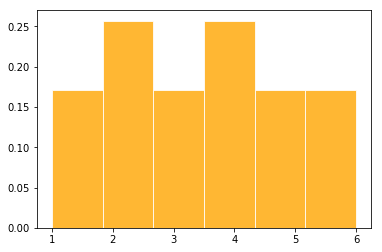

fraction of nights Band 1=15.7%, 2=23.3%, 3=16.0%, 4=20.7% and 5=17.8%

fraction of nights Band 1=0.14285714285714285%, 2=0.21428571428571427%, 3=0.14285714285714285%, 4=0.21428571428571427% and 5=0.14285714285714285%



In [48]:
#Plot histogram of days:
plt.figure()
plt.hist(MonthLAPSdata['Weather'], bins=6, label='default', edgecolor='white', facecolor='orange', alpha=0.8, normed=1)
plt.show()
print (("fraction of nights Band 1={}%, 2={}%, 3={}%, 4={}% and 5={}%\n".format(wdata['Band1Percentage'][dict[month]],wdata['Band2Percentage'][dict[month]],wdata['Band3Percentage'][dict[month]],wdata['Band4Percentage'][dict[month]],wdata['Band5Percentage'][dict[month]])))
print (("fraction of nights Band 1={:}%, 2={}%, 3={}%, 4={}% and 5={}%\n".format(modelband1frac,modelband2frac,modelband3frac,modelband4frac,modelband5frac)))


In essence I then need to calculate how many night in a month are in each weatherbands and run Michael's code on the relevent 